In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds

In [84]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'fashion_mnist',
    split=['train[:80%]', 'train[80%:]', 'test'],
    with_info=True,
    as_supervised=True,
)

In [85]:
print(raw_train)
print(raw_validation)
print(raw_test)

<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>


In [96]:
IMG_SIZE = 150 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = tf.image.grayscale_to_rgb(image)
  return image, label

In [97]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [98]:
print(train)
print(validation)
print(test)

<DatasetV1Adapter shapes: ((150, 150, 3), ()), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((150, 150, 3), ()), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((150, 150, 3), ()), types: (tf.float32, tf.int64)>


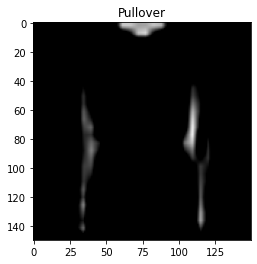

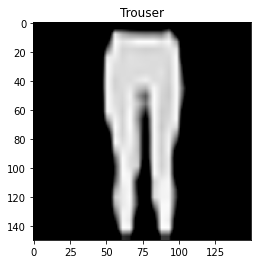

In [99]:
get_label_name = metadata.features['label'].int2str

for image, label in train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [100]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [101]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [102]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 150, 150, 3])

In [103]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.VGG19(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=IMG_SHAPE,
    pooling=None, classes=10, classifier_activation='softmax'
)

In [104]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 512)


In [105]:
base_model.trainable = False

In [106]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [107]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [108]:
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [109]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [110]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [111]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 20,029,514
Trainable params: 5,130
Non-trainable params: 20,024,384
_________________________________________________________________


In [112]:
len(model.trainable_variables)

2

In [113]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 166s 8s/step - loss: 2.4820 - accuracy: 0.1141


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
 297/1250 [======>.......................] - ETA: 9:29 - loss: 1.7693 - accuracy: 0.1025

KeyboardInterrupt: ignored